# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---

## Import Packages

In [52]:
### Importing necessary packages

import numpy as np                  # For handling images
import glob                         # For iterating through multiple image files
import pickle                       # To save data to file
import cv2                          # For image manipulation
import matplotlib.pyplot as plt     # For plotting images

# For plotting to display inline within the notebook
%matplotlib inline

print("All package import complete")

All package import complete


## Define Global Variables

In [230]:
### Define Global variables

prev_clip_data = [0, 0, 0, 0]        # Slope & intercept from previous clip used as reference to filter outliers
bottom_y = 0                         # Variable to hold the bottom most starting point

# constants
SLOPE_TOLERANCE = 0.5                # Used to derieve allowed slope range based on on previous clip slope
INTERCEPT_TOLERANCE = 25             # Used to derieve allowed intecept range based on on previous clip intercept
TOP_Y_FACTOR = 0                     # Factor that decides the top edge of mask
BOTTOM_Y_FACTOR = 1                  # Factor that decides the bottom edge of mask
MASK_BOTTOM_RIGHT_X_FACTOR = 0.8    # Factor that decides the bottom right position of mask
MASK_BOTTOM_LEFT_X_FACTOR = 0.2     # Factor that decides the bottom left position of mask
MASK_TOP_RIGHT_X_FACTOR = 0.8       # Factor that decides the top right position of mask
MASK_TOP_LEFT_X_FACTOR = 0.2        # Factor that decides the top left position of mask

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

print("All global variable definition complete")

All global variable definition complete


## Read in an Image

Below are some helper functions to help get you started. They should look familiar from the lesson!

Image is of type : <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


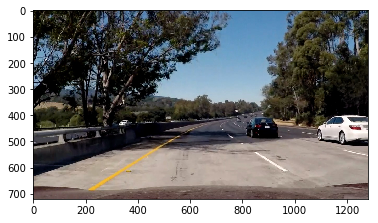

In [49]:
### Reading in an image
image = cv2.imread('test_images/test5.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Printing out some stats and plotting
print('Image is of type :', type(image), 'with dimensions:', image.shape)
plt.imshow(image)
plt.show()

## Caliberate Camera

Below are some helper functions to help get you started. They should look familiar from the lesson!

(1280, 720)
Camera caliberated.  mtx =  [[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]  dist =  [[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318543e-04
    2.67124302e-02]]


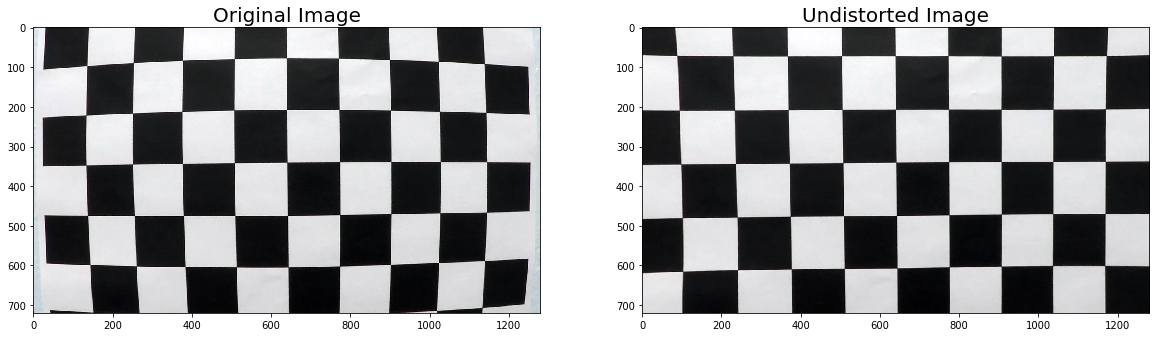

In [4]:
### Caliberate Camera

# Chessboard corners
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)


# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/cal*.jpg')

cv2.startWindowThread() 
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name = 'camera_cal/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
#        cv2.imshow('img', img)
#        cv2.waitKey(500)

#cv2.destroyAllWindows()


# Get chessboard image size
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
print(img_size)

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
print("Camera caliberated.  mtx = ", mtx, " dist = ", dist)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist.jpg',dst)

# Save the camera calibration result for later use 
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)
plt.show()

## Compute Perspective Transform

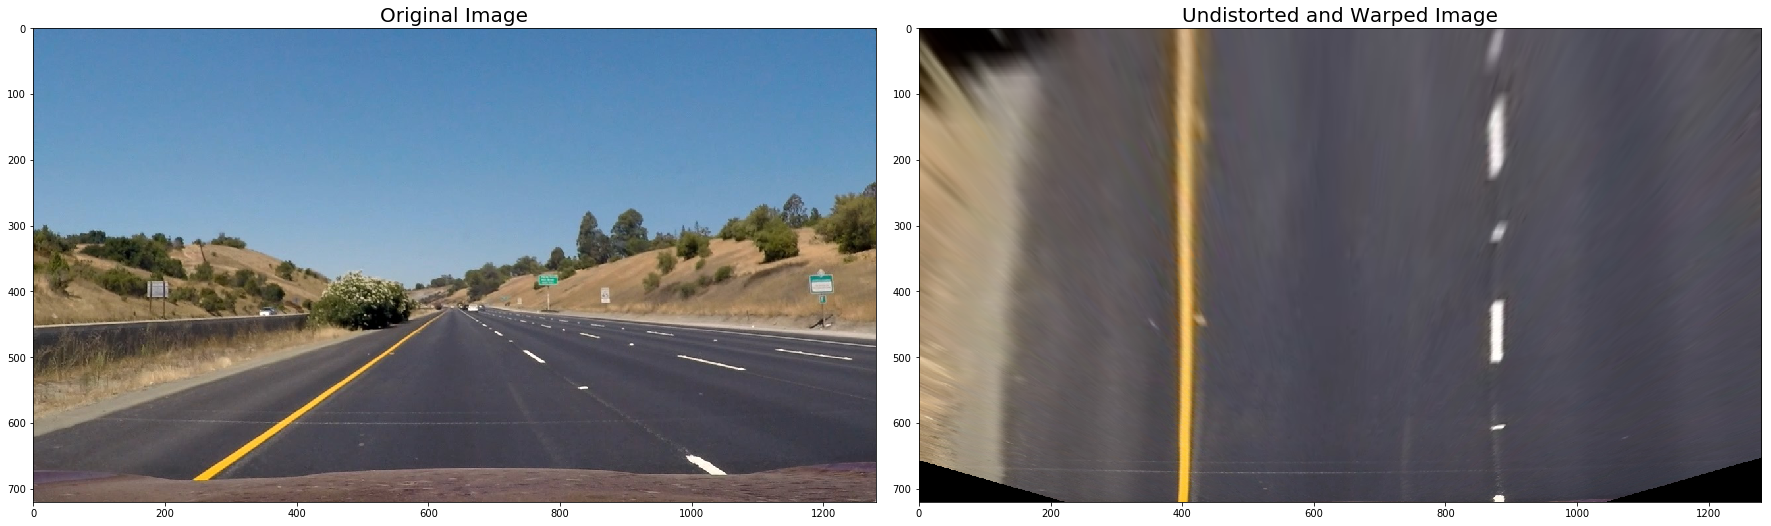

In [39]:
### Compute Perspective Transform (M)

# Read in an image
img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#Convert to gray scale
gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)

def corners_unwarp(img, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    # 2) Convert to grayscale
    # 3) Find the chessboard corners
    # 4) If corners found: 
            # a) draw corners
            # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
                 #Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 #One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 #We recommend using the automatic detection of corners in your code
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
            # e) use cv2.warpPerspective() to warp your image to a top-down view
    
    #Undistorting the image
    dst = cv2.undistort(img, mtx, dist, None, mtx)
   

    
    #Set source and destination image co-ordinates
    xoffset = 400 # offset for dst points
    yoffset = 10 # offset for dst points

#    src = np.float32([[611,441],[669,441],[998,650],[305,650]])
    src = np.float32([[588,455],[694,455],[998,650],[305,650]])
    dst = np.float32([[xoffset, yoffset], [img_size[0]-xoffset, yoffset], 
                                     [img_size[0]-xoffset, img_size[1]-yoffset], 
                                     [xoffset, img_size[1]-yoffset]])
    
    # Calculate Perspective Transform
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Warp the image using the perspective transform M
    warped = cv2.warpPerspective(img, M, gray.shape[::-1], flags=cv2.INTER_LINEAR)
    return warped, M

top_down, perspective_M = corners_unwarp(img, mtx, dist)

warped_images = []
images = glob.glob('test_images/*.jpg')
for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    warped_image = cv2.warpPerspective(image, perspective_M, gray.shape[::-1], flags=cv2.INTER_LINEAR)
    
    # Plot the images for review
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(warped_image)
    ax2.set_title('Undistorted and Warped Image', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
### Verify Curvature

## Pipeline support functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [335]:
### Support Functions

def showImg(Img):
    plt.imshow(Img)
    plt.show()
    return

def showGrayImg(Img):
    plt.imshow(Img, cmap="gray")
    plt.show()
    return

def grayscale(img):
    """Applies the Grayscale transform
       This will return an image with only one color channel"""
    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def gradient(gray, orient, sobel_kernel, thresh):
    """ Calculates directional gradient in the required orientation
        Applies threshold"""
    
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def gradient_mag(gray, sobel_kernel, mag_thresh):
    """ Calculates gradient magnitude
        Applies threshold"""

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt( (sobelx*sobelx) + (sobely*sobely) )
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    return mag_binary

def gradient_dir(gray, sobel_kernel, dir_thresh):
    """ Calculates gradient direction
        Applies threshold"""
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
#    scaled_dir_grad = np.uint8(255*dir_grad/np.max(dir_grad))
    dir_binary = np.zeros_like(dir_grad)
    dir_binary[(dir_grad >= dir_thresh[0]) & (dir_grad <= dir_thresh[1])] = 1
    return dir_binary

# Define a function that thresholds the S-channel of HLS
def s_select(img, thresh):
    """ 1) Converts image to HLS color space
        2) Apply a threshold to the S channel
        3) Return a binary image of threshold result """
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    img_s = img[:,:,2]

    sbinary = np.zeros_like(img_s)
    sbinary[(img_s > thresh[0]) & (img_s <= thresh[1])] = 1
    return sbinary

def l_select(img, thresh):
    """ 1) Converts image to HLS color space
        2) Apply a threshold to the S channel
        3) Return a binary image of threshold result """
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    img_l = img[:,:,1]

    lbinary = np.zeros_like(img_l)
    lbinary[(img_l > thresh[0]) & (img_l <= thresh[1])] = 1
    return lbinary

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    mask_bottom_right_x = img.shape[1] * MASK_BOTTOM_RIGHT_X_FACTOR
    mask_bottom_left_x = img.shape[1] * MASK_BOTTOM_LEFT_X_FACTOR
    mask_top_right_x = img.shape[1] * MASK_TOP_RIGHT_X_FACTOR
    mask_top_left_x = img.shape[1] * MASK_TOP_LEFT_X_FACTOR
    mask_top_y = img.shape[0] * TOP_Y_FACTOR
    mask_bottom_y = img.shape[0] * BOTTOM_Y_FACTOR

    
    vertices = np.array([[(mask_top_left_x, mask_top_y), (mask_top_right_x, mask_top_y),  \
                          (mask_bottom_right_x, mask_bottom_y), (mask_bottom_left_x, mask_bottom_y)]],  \
                             dtype=np.int32) # vertices of the masked area

    #defining a blank mask to start with
    mask = np.zeros_like(img)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image

def calculate_curvature(y_eval, fit):
    """Calculates the radius of curvature of a given line"""
    # y_eval : y-value where we want radius of curvature
    # fit : left or right line fit
    return ((1 + (2*fit[0]*y_eval + fit[1])**2)**1.5) / np.absolute(2*fit[0])

## Validate parameters on Test Images

The parameters are validated on some test images to make sure the solution is good before applying the pipeline to videos.


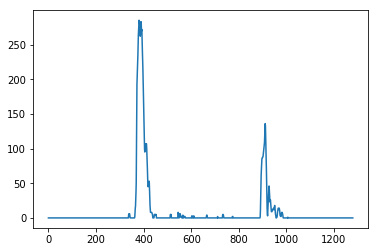

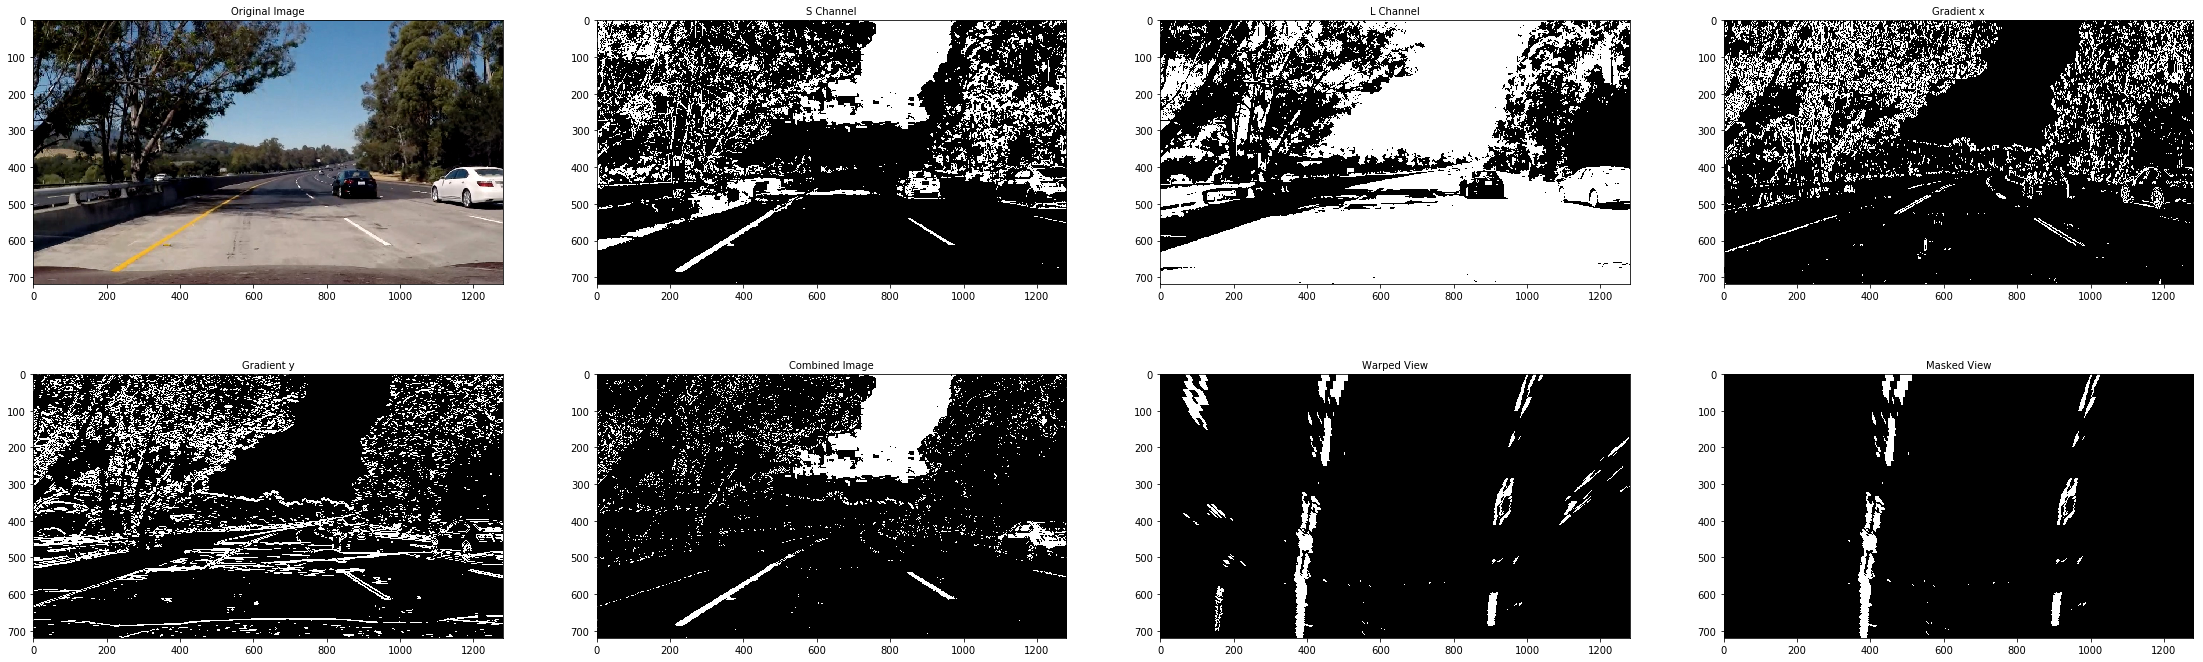

In [242]:
images = glob.glob('test_images/*.jpg')
for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    s_chn_img = s_select(image, thresh=(100,255))
    l_chn_img = l_select(image, thresh=(50,255))
    gray_img = grayscale(image)
    sobelx_img = gradient(gray_img, orient='x', sobel_kernel=9, thresh=(20,100))
    sobely_img = gradient(gray_img, orient='y', sobel_kernel=9, thresh=(20,100))
    sobel_mag = gradient_mag(gray_img, sobel_kernel=3, mag_thresh=(20,100))
    sobel_dir = gradient_dir(gray_img, sobel_kernel=31, dir_thresh=(0.7,1.3))
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sobelx_img), sobelx_img, s_chn_img))
    
    # Combine the two binary thresholds
    combined_img = np.zeros_like(sobelx_img)
#    combined_img[(s_chn_img == 1) | (sobelx_img == 1)] = 1
#    combined_img[(sobel_mag == 1) & (sobel_mag == 1)] = 1
    combined_img[((s_chn_img == 1) | ((sobelx_img == 1) & (sobely_img ==1))) & ((l_chn_img == 1))] = 1

    combined_img2 = np.zeros_like(sobelx_img)
    combined_img2[((s_chn_img == 1) & (l_chn_img == 1))] = 1
    
    combined_img3 = np.zeros_like(sobelx_img)
    combined_img3[((sobelx_img == 1) & (sobely_img ==1))] = 1
    
    combined_img4 = np.zeros_like(sobelx_img)
    combined_img4[((combined_img2 == 1) | (combined_img3 ==1))] = 1
    
    warped_image = cv2.warpPerspective(combined_img4, perspective_M, gray.shape[::-1], flags=cv2.INTER_LINEAR)
    masked_image = region_of_interest(warped_image)

    
    # Plot the images for review
    f = plt.figure(figsize=(30, 18))
#    f.tight_layout()
#    f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(8, 4, figsize=(20, 12))
    ax1 = plt.subplot(2, 4, 1)
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=10)
    ax2 = plt.subplot(2, 4, 2)
    ax2.imshow(s_chn_img, cmap='gray')
    ax2.set_title('S Channel', fontsize=10)
    ax3 = plt.subplot(2, 4, 3)
    ax3.imshow(l_chn_img, cmap='gray')
    ax3.set_title('L Channel', fontsize=10)
    ax4 = plt.subplot(2, 4, 4)
    ax4.imshow(sobelx_img, cmap="gray")
    ax4.set_title('Gradient x', fontsize=10)
    ax5 = plt.subplot(2, 4, 5)
    ax5.imshow(sobely_img, cmap="gray")
    ax5.set_title('Gradient y', fontsize=10)
    ax6 = plt.subplot(2, 4, 6)
    ax6.imshow(combined_img, cmap="gray")
    ax6.set_title('Combined Image', fontsize=10)
    ax7 = plt.subplot(2, 4, 7)
    ax7.imshow(warped_image, cmap="gray")
    ax7.set_title('Warped View', fontsize=10)
    ax8 = plt.subplot(2, 4, 8)
    ax8.imshow(masked_image, cmap="gray")
    ax8.set_title('Masked View', fontsize=10)
    plt.subplots_adjust(left=0., right=1, top=0.5, bottom=0.)
    f.savefig('Inflight_' + str(idx))

In [246]:
def get_binary_warp(image):

    s_chn_img = s_select(image, thresh=(100,255))
    l_chn_img = l_select(image, thresh=(50,255))
    gray_img = grayscale(image)
    sobelx_img = gradient(gray_img, orient='x', sobel_kernel=9, thresh=(20,100))
    sobely_img = gradient(gray_img, orient='y', sobel_kernel=9, thresh=(20,100))
    sobel_mag = gradient_mag(gray_img, sobel_kernel=3, mag_thresh=(20,100))
    sobel_dir = gradient_dir(gray_img, sobel_kernel=31, dir_thresh=(0.7,1.3))
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sobelx_img), sobelx_img, s_chn_img))
    
    # Combine the two binary thresholds
    combined_img = np.zeros_like(sobelx_img)
#    combined_img[(s_chn_img == 1) | (sobelx_img == 1)] = 1
#    combined_img[(sobel_mag == 1) & (sobel_mag == 1)] = 1
    combined_img[((s_chn_img == 1) | ((sobelx_img == 1) & (sobely_img ==1))) & ((l_chn_img == 1))] = 1

    combined_img2 = np.zeros_like(sobelx_img)
    combined_img2[((s_chn_img == 1) & (l_chn_img == 1))] = 1
    
    combined_img3 = np.zeros_like(sobelx_img)
    combined_img3[((sobelx_img == 1) & (sobely_img ==1))] = 1
    
    combined_img4 = np.zeros_like(sobelx_img)
    combined_img4[((combined_img2 == 1) | (combined_img3 ==1))] = 1
    
    warped_image = cv2.warpPerspective(combined_img4, perspective_M, gray.shape[::-1], flags=cv2.INTER_LINEAR)
    masked_image = region_of_interest(warped_image)

    """
    # Plot the images for review
    f = plt.figure(figsize=(30, 18))
#    f.tight_layout()
#    f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(8, 4, figsize=(20, 12))
    ax1 = plt.subplot(2, 4, 1)
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=10)
    ax2 = plt.subplot(2, 4, 2)
    ax2.imshow(s_chn_img, cmap='gray')
    ax2.set_title('S Channel', fontsize=10)
    ax3 = plt.subplot(2, 4, 3)
    ax3.imshow(l_chn_img, cmap='gray')
    ax3.set_title('L Channel', fontsize=10)
    ax4 = plt.subplot(2, 4, 4)
    ax4.imshow(sobelx_img, cmap="gray")
    ax4.set_title('Gradient x', fontsize=10)
    ax5 = plt.subplot(2, 4, 5)
    ax5.imshow(sobely_img, cmap="gray")
    ax5.set_title('Gradient y', fontsize=10)
    ax6 = plt.subplot(2, 4, 6)
    ax6.imshow(combined_img, cmap="gray")
    ax6.set_title('Combined Image', fontsize=10)
    ax7 = plt.subplot(2, 4, 7)
    ax7.imshow(warped_image, cmap="gray")
    ax7.set_title('Warped View', fontsize=10)
    ax8 = plt.subplot(2, 4, 8)
    ax8.imshow(masked_image, cmap="gray")
    ax8.set_title('Masked View', fontsize=10)
    plt.subplots_adjust(left=0., right=1, top=0.5, bottom=0.)
    f.savefig('Inflight_' + str(idx))
    
    """
    
    return masked_image

C:\Users\ADMIN\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


23900.1154077 122022.520772
7872.91129763 40082.8746575


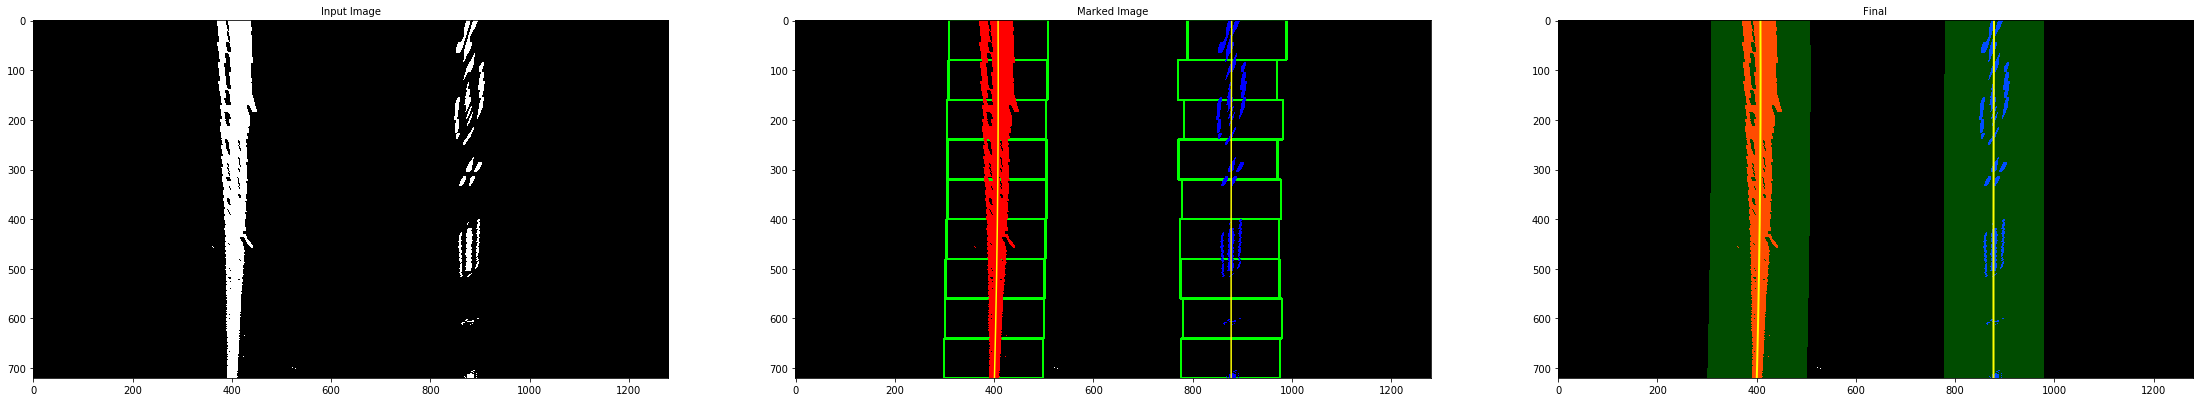

In [343]:
def draw_lanes(binary_warped):
    
#    showGrayImg(binary_warped)
        
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
 
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Draw images
    f = plt.figure(figsize=(30, 18))
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(binary_warped, cmap='gray')
    ax1.set_title('Input Image', fontsize=10)
    
    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(out_img, cmap='gray')
    ax2.plot(left_fitx, ploty, color='yellow')
    ax2.plot(right_fitx, ploty, color='yellow')
    ax2.set_title('Marked Image', fontsize=10)
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    window_img = np.zeros_like(out_img)
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
 
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(result, cmap='gray')
    ax3.set_title('Final', fontsize=10)
    ax3.plot(left_fitx, ploty, color='yellow', linewidth=2)
    ax3.plot(right_fitx, ploty, color='yellow', linewidth=2)

    plt.subplots_adjust(left=0., right=1, top=0.5, bottom=0.)
    
    """
    f = plt.figure(figsize=(30, 18))
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(binary_warped, cmap="gray")
    ax1.set_title('Input Image', fontsize=10)
    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(out_img, cmap='gray')
    ax2.set_title('Marked Image', fontsize=10)
    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(result, cmap='gray')
    ax3.set_title('Final', fontsize=10)
    plt.subplots_adjust(left=0., right=1, top=0.5, bottom=0.)
    """

    # Calculate radius of curvature
    left_curverad = calculate_curvature(np.max(ploty)/2, left_fit)
    right_curverad = calculate_curvature(np.max(ploty)/2, right_fit)
    print(left_curverad, right_curverad)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    left_curverad = calculate_curvature(np.max(ploty)/2, left_fit_cr)
    right_curverad = calculate_curvature(np.max(ploty)/2, right_fit_cr)
    print(left_curverad, right_curverad)

    return
        
        
images = glob.glob('test_images/*.jpg')
for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    binary_warped = get_binary_warp(image)
    draw_lanes(binary_warped)



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

1782.15355353 1948.36362223
869.462004102 886.826011774


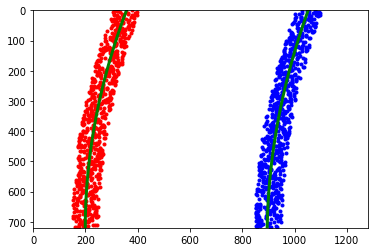

In [341]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

left_curverad = calculate_curvature(np.max(ploty)/2, left_fit)
right_curverad = calculate_curvature(np.max(ploty)/2, right_fit)
print(left_curverad, right_curverad)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

left_curverad = calculate_curvature(np.max(ploty)/2, left_fit_cr)
right_curverad = calculate_curvature(np.max(ploty)/2, right_fit_cr)
print(left_curverad, right_curverad)

In [ ]:
def pipeline(input_image):
    """
    Pipeline that will draw lane lines on the test_images and then save them to the test_images directory.
    """
    
    gaussian_kernel_size = 7  # kernel size used for gaussian blur
    canny_low_threshold = 40 # pixel with gradient below the low threshold are rejected
    canny_high_threshold = 100 # gradient used to detect strong edges
    
    
    mask_bottom_right_x = input_image.shape[1] * MASK_BOTTOM_RIGHT_X_FACTOR
    mask_bottom_left_x = input_image.shape[1] * MASK_BOTTOM_LEFT_X_FACTOR
    mask_top_right_x = input_image.shape[1] * MASK_TOP_RIGHT_X_FACTOR
    mask_top_left_x = input_image.shape[1] * MASK_TOP_LEFT_X_FACTOR
    mask_top_y = input_image.shape[0] * TOP_Y_FACTOR
    mask_bottom_y = input_image.shape[0] * BOTTOM_Y_FACTOR

    
    vertices = np.array([[(mask_top_left_x, mask_top_y), (mask_top_right_x, mask_top_y),  \
                          (mask_bottom_right_x, mask_bottom_y), (mask_bottom_left_x, mask_bottom_y)]],  \
                             dtype=np.int32) # vertices of the masked area
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 60     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap = 30    # maximum gap in pixels between connectable line segments
    
    grayscale_image = grayscale(input_image)
#    print ("gray image")
#    plt.imshow(grayscale_image, cmap='gray')

    gaussian_blurred_image = gaussian_blur(grayscale_image, gaussian_kernel_size)
#    print ("gaussian image")
#    plt.imshow(gaussian_blurred_image, cmap='gray')

    canny_image = canny(gaussian_blurred_image, canny_low_threshold, canny_high_threshold)
#    print ("canny image")
#    plt.imshow(canny_image, cmap='gray')
#    plt.imsave('canny.png', canny_image, format='png', cmap='gray')

    masked_image = region_of_interest(canny_image, vertices)
#    print ("masked image")
#    plt.imshow(masked_image, cmap='gray')
#    plt.show()

    hough_image = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)
#    print ("hough image")
#    plt.imshow(hough_image, cmap='gray')
#    plt.show()

    weighted_image = weighted_img(hough_image, input_image)
#    print ("weighted image")
#    plt.imshow(weighted_image)
    
    return weighted_image

'''
NOTE : This section is used to test the pipeline against the set of test images provided
'''

images = os.listdir('test_images/')

for image in images:
    
    if image[:6] != 'Output':
        input_image = cv2.imread('test_images/%s' % image)
        print('processing image ', image)
        prev_clip_data = [0, 0, 0, 0]
        bottom_y = 0
        output_image = pipeline(input_image)
        output_img_name = 'Output2_' + image
        cv2.imsave('test_images/%s' % output_img_name, output_image)
    else:
        print('ignoring image ', image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!



In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # Calling pipeline that will return the final output (image where lines are drawn on lanes)
        
    result = pipeline(image)

    return result

Let's try the one with the solid white lane on the right first ...

In [ ]:
prev_clip_data = [0, 0, 0, 0]
bottom_y = 0
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
prev_clip_data = [0, 0, 0, 0]
bottom_y = 0
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
prev_clip_data = [0, 0, 0, 0]
bottom_y = 0
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

## HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [ ]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    This section iterates through the line co-ordinates returned by Hough transform and
    calculates the average slope (m) and intercept (b) for left lane and right lane seperately.
    Positive slope is considered as right lane and negative slope is considered as left lane.
    
    The following filters are applied :
        1. Lines with slope^2 outside the range of 0.1 and 100 are filtered out as horizontal lines
        2. Lines with slope < 0 (left lane) but lying to the right of center are filtered
        3. Lines with slope > 0 (right lane) but lying to the left of center are filtered
        4. Lines with slope & intercept beyond the allowed variance are filtered.

    The mean of slope and intercept of valid left side lines is calculated as the left lane slope & intecept.
    The mean of slope and intercept of valid right side lines is calculated as the left lane slope & intecept.

    The left and right lanes are extrapolated by determining top and bottom x values using y = mx + b
    for y = top and bottom edge of mask
    
    The extrapolated lines are then drawn to produce the image.
    """

    global prev_clip_data                    # Array that holds the slope & intercept of previous clip
    global bottom_y                          # Variable that holds the bottom most y value

    prev_left_slope = prev_clip_data[0]      # Variable that holds the slope of left lane from previous clip
    prev_left_intercept = prev_clip_data[1]  # Variable that holds the intercept of left lane from previous clip
    prev_right_slope = prev_clip_data[2]     # Variable that holds the slope of right lane from previous clip
    prev_right_intercept = prev_clip_data[3] # Variable that holds the intercept of right lane from previous clip

    left_lane_slope_accumulator = 0.0        # Variable used to accumulate left lane slope to calculate mean
    left_lane_intercept_accumulator = 0.0    # Variable used to accumulate left lane intercept to calculate mean
    left_lane_line_counter = 0               # Variable used to count the number of valid left lanes
    left_lane_intercept_average = 0.0        # Variable used to hold the left lane intercept average
    right_lane_slope_accumulator = 0.0       # Variable used to accumulate right lane slope to calculate mean       
    right_lane_intercept_accumulator = 0.0   # Variable used to accumulate right lane intercept to calculate mean
    right_lane_line_counter = 0              # Variable used to count the number of valid right lanes
    right_lane_slope_average = 0.0           # Variable used to hold the right lane intercept average
    right_lane_intercept_average = 0.0       # Variable used to hold the right lane intercept average

    top_y = int(img.shape[0] * TOP_Y_FACTOR) # Calculates the top edge of mask to be used in extrapolation

    if prev_left_slope == 0:                 # Identifies the very first clip and uses logic without prev clip reference
        for line in lines:
            for x1, y1, x2, y2 in line:
                slope, intercept = np.polyfit([x1, x2], [y1, y2], 1)   # Calculate slope & intercept
                if((slope*slope) > 0.1) & ((slope*slope) < 100):       # Filters out horizontal lines 
#                    cv2.line(img, (x1, y1), (x2, y2), color=[0, 255, 0], thickness=2)
                    if y1 > bottom_y:                                  # Reposition bottom edge if line is lower
                        bottom_y = y1
                    if y2 > bottom_y:                                  # Reposition bottom edge if line is lower
                        bottom_y = y2
                    if slope < 0:                                      # Identifies lane position as left or right
                        left_lane_slope_accumulator += slope
                        left_lane_intercept_accumulator += intercept
                        left_lane_line_counter += 1
                    else:
                        right_lane_slope_accumulator += slope
                        right_lane_intercept_accumulator += intercept
                        right_lane_line_counter += 1
                else:
#                    print ('ignoring line ', line, ' as outlier ', slope, intercept)
#                    cv2.line(img, (x1, y1), (x2, y2), color=[0, 0, 255], thickness=2)
                    pass
        
        """
        Below section calculates the mean of slope and intercept for left and right lanes seperately using 
        filtered out lines.  
        """
        if left_lane_line_counter != 0:                                    # handle division by zero scenario
            left_lane_slope_average = left_lane_slope_accumulator / left_lane_line_counter
            left_lane_intercept_average = left_lane_intercept_accumulator / left_lane_line_counter
            left_lane_top_x = (top_y - left_lane_intercept_average)/ left_lane_slope_average
            left_lane_bottom_x = (bottom_y - left_lane_intercept_average) / left_lane_slope_average
            cv2.line(img, (int(left_lane_bottom_x), bottom_y), (int(left_lane_top_x), top_y), color, thickness)

        if right_lane_line_counter != 0:                                    # handle division by zero scenario
            right_lane_slope_average = right_lane_slope_accumulator / right_lane_line_counter
            right_lane_intercept_average = right_lane_intercept_accumulator / right_lane_line_counter
            right_lane_top_x = (top_y - right_lane_intercept_average) / right_lane_slope_average
            right_lane_bottom_x = (bottom_y - right_lane_intercept_average) / right_lane_slope_average
            cv2.line(img, (int(right_lane_bottom_x), bottom_y), (int(right_lane_top_x), top_y), color, thickness)

        prev_clip_data = [left_lane_slope_average, left_lane_intercept_average, 
                             right_lane_slope_average, right_lane_intercept_average]
#        print('current clip data =', prev_clip_data)

    else:
        left_lane_slope_accumulator = prev_left_slope                 # Use slope and intercept from previous
        left_lane_intercept_accumulator = prev_left_intercept         # clip as one of the valid lines. This  
        left_lane_line_counter = 1                                    # will help increase the weight for valid
        right_lane_slope_accumulator = prev_right_slope               # lines in current clip and also act as 
        right_lane_intercept_accumulator = prev_right_intercept       # reference in case no line could be detected
        right_lane_line_counter = 1
        
        for line in lines:
            for x1, y1, x2, y2 in line:
                slope, intercept = np.polyfit([x1, x2], [y1, y2], 1)  # calculate slope & intercept
                if((slope*slope) > 0.1) & ((slope*slope) < 100):      # filter out horizontal lines
                    if slope < 0:                                     # Line slope < 0 is considered left lane line
                        if x1 < (img.shape[1]/2):                     # Check if line is in left side of image
                            """
                            The below condition checks if a line is within the tolerance range using previous
                            clip slope and intercept as reference
                            """
                            if ((prev_left_slope-SLOPE_TOLERANCE) < slope < (prev_left_slope+SLOPE_TOLERANCE)) & \
                             ((prev_left_intercept-INTERCEPT_TOLERANCE) < intercept < \
                                (prev_left_intercept+INTERCEPT_TOLERANCE)):
                                left_lane_slope_accumulator += slope
                                left_lane_intercept_accumulator += intercept
                                left_lane_line_counter += 1
#                                cv2.line(img, (x1, y1), (x2, y2), color=[0, 255, 0], thickness=20)
#                               print('green data left =', slope, intercept)
                                if y1 > bottom_y:                    # Reposition bottom edge if line is lower
                                    bottom_y = y1
                                if y2 > bottom_y:                    # Reposition bottom edge if line is lower
                                    bottom_y = y2
                            else:
#                                print('ignoring line ', line, ' as outlier ', slope, intercept)
#                               cv2.line(img, (x1, y1), (x2, y2), color=[0, 0, 255], thickness=2)
                                pass
                        else:
#                           print('ignoring line ', line, ' as outlier ', slope, intercept)
#                            cv2.line(img, (x1, y1), (x2, y2), color=[240, 66, 236], thickness=2)
                            pass
                    else:
                        if x1 > (img.shape[1]/2):                   # Check if line is in right side of image
                            """
                            The below condition checks if a line is within the tolerance range using previous
                            clip slope and intercept as reference
                            """
                            if ((prev_right_slope-SLOPE_TOLERANCE) < slope < (prev_right_slope+SLOPE_TOLERANCE)) & \
                                ((prev_right_intercept-INTERCEPT_TOLERANCE) < \
                                    intercept < (prev_right_intercept+INTERCEPT_TOLERANCE)):
                                right_lane_slope_accumulator += slope
                                right_lane_intercept_accumulator += intercept
                                right_lane_line_counter += 1
#                                cv2.line(img, (x1, y1), (x2, y2), color=[0, 255, 0], thickness=20)
#                                print('green data right =', slope, intercept)
                                if y1 > bottom_y:                        # Reposition bottom edge if line is lower
                                    bottom_y = y1
                                if y2 > bottom_y:                        # Reposition bottom edge if line is lower
                                    bottom_y = y2
                            else:
#                               print('ignoring line ', line, ' as outlier ', slope, intercept)
#                                cv2.line(img, (x1, y1), (x2, y2), color=[0, 0, 255], thickness=2)
                                pass
                        else:
#                           print('ignoring line ', line, ' as outlier ', slope, intercept)
#                            cv2.line(img, (x1, y1), (x2, y2), color=[240, 66, 236], thickness=2)
                            pass
                else:
#                   print('ignoring line ', line, ' as outlier ', slope, intercept)
#                    cv2.line(img, (x1, y1), (x2, y2), color=[252, 255, 111], thickness=2)
                    pass

        """
        Below section calculates the mean of slope and intercept for left and right lanes seperately using 
        filtered out lines.  
        """
        left_lane_slope_average = left_lane_slope_accumulator / left_lane_line_counter
        left_lane_intercept_average = left_lane_intercept_accumulator / left_lane_line_counter
        left_lane_top_x = (top_y - left_lane_intercept_average) / left_lane_slope_average
        left_lane_bottom_x = (bottom_y - left_lane_intercept_average) / left_lane_slope_average
        cv2.line(img, (int(left_lane_bottom_x), bottom_y), (int(left_lane_top_x), top_y), color, thickness)

        right_lane_slope_average = right_lane_slope_accumulator / right_lane_line_counter
        right_lane_intercept_average = right_lane_intercept_accumulator / right_lane_line_counter
        right_lane_top_x = (top_y - right_lane_intercept_average) / right_lane_slope_average
        right_lane_bottom_x = (bottom_y - right_lane_intercept_average) / right_lane_slope_average
        cv2.line(img, (int(right_lane_bottom_x), bottom_y), (int(right_lane_top_x), top_y), color, thickness)

        """
        Set the previous clip data to the current clip data so that it can be used for next clip
        """
        prev_clip_data = [left_lane_slope_average, left_lane_intercept_average,  
                             right_lane_slope_average, right_lane_intercept_average]

#        print('current clip data =', prev_clip_data)
    
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    draw_lines(line_img, lines)
    return line_img


def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    Blends the orginial image with the image containing identified lane lines
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)